In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(2115, 22, 1000)


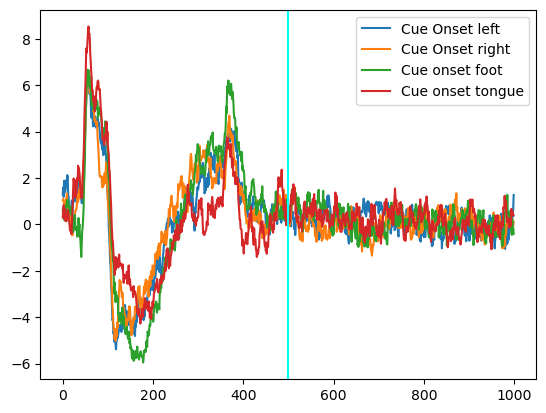

In [3]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
person_train_valid = np.load("data/person_train_valid.npy")
X_train_valid = np.load("data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("data/y_train_valid.npy")
person_test = np.load("data/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [4]:

## Preprocessing the dataset

X_train_valid_prep = X_train_valid[:,:,0:500]
X_test_prep = X_test[:,:,0:500]




print(X_train_valid_prep.shape)
print(y_train_valid.shape)
print(X_test_prep.shape)
print(y_test.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)





    




(2115, 22, 500)
(2115,)
(443, 22, 500)
(443,)
Shape of training set: (1615, 22, 500)
Shape of validation set: (500, 22, 500)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 500, 1)
Shape of validation set after adding width info: (500, 22, 500, 1)
Shape of test set after adding width info: (443, 22, 500, 1)
Shape of training set after dimension reshaping: (1615, 500, 1, 22)
Shape of validation set after dimension reshaping: (500, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)


In [10]:
import math
from tempfile import TemporaryDirectory
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from typing import Tuple
import os
import torch.nn.init as init

In [11]:

x_train = torch.from_numpy(x_train)
x_valid = torch.from_numpy(x_valid)
x_test = torch.from_numpy(x_test)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [12]:

y_train= torch.from_numpy(y_train)
y_valid= torch.from_numpy(y_valid)
y_test = torch.from_numpy(y_test)

In [82]:


class TransformerClassificationHead(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TransformerClassificationHead, self).__init__()

        # Global average pooling layer
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)        

        # Output layer
        self.output_layer = nn.Linear(input_size, num_classes)
        init.xavier_uniform_(self.output_layer.weight)
        init.zeros_(self.output_layer.bias)

        # Softmax activation
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Global average pooling

        x = self.global_avg_pooling(x.permute(0, 2, 1)).squeeze(-1)
        
        x = self.output_layer(x)
        x = self.softmax(x)
       
     

        return x



In [176]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

def train(model, input_array, ground_truth_array, num_epochs=1, batch_size=64, learning_rate=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    #optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #scheduler = StepLR(optimizer, step_size=20, gamma=0.01) 

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i in range(0, len(input_array), batch_size):
            batch_inputs = input_array[i:i + batch_size]
            batch_labels = ground_truth_array[i:i + batch_size]

            batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
            batch_labels = torch.tensor(batch_labels, dtype=torch.long)


            optimizer.zero_grad()
            outputs = model(batch_inputs)
            
           
            loss = criterion(outputs, batch_labels.float())
   

        # Add L1 regularization term to the loss
      
            #loss = loss +  0.0009 * torch.norm(model.parameters(), 1)
        
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
           
            predictions = torch.argmax(outputs, dim=1)
            total_samples += batch_labels.size(0)
            
            actual =  torch.argmax(torch.transpose(batch_labels, 0, 1), dim=0)

            
            correct_predictions += (predictions == actual).sum().item()

        average_loss = total_loss / (len(input_array) / batch_size)
        average_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss}, Accuracy: {average_accuracy}')
    return average_accuracy, average_loss
    
        


In [80]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, dropout: float = 0.1, max_length: int = 500):
    """
    Args:
      d_model:      dimension of embeddings
      dropout:      randomly zeroes-out some of the input
      max_length:   max sequence length
    """
    # inherit from Module
    super().__init__()     
    self.dropout = nn.Dropout(p=dropout)      
    pe = torch.zeros(max_length, d_model)    
    k = torch.arange(0, max_length).unsqueeze(1)  
    div_term = torch.exp(                                 
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
    )
    pe[:, 0::2] = torch.sin(k * div_term)    
    pe[:, 1::2] = torch.cos(k * div_term)  
    pe = pe.unsqueeze(0)          
    self.register_buffer("pe", pe)                        

  def forward(self, x: Tensor):
    """
    Args:
      x:        embeddings (batch_size, seq_length, d_model)
    
    Returns:
                embeddings + positional encodings (batch_size, seq_length, d_model)
    """
    pos_emb = (self.pe[:, : x.size(1)].requires_grad_(False) ).permute(1,0,2)
  
    x = x + pos_emb
  
    return self.dropout(x)

In [174]:
class MyTransformerArch1(nn.Module):
    def __init__(self, input_dim, hidden_dim, nhead, nlayers, output_dim):
        super(MyTransformerArch1, self).__init__()
        self.transformer = nn.Transformer(
            d_model=input_dim,
            nhead=nhead,
            num_encoder_layers=nlayers,
            dim_feedforward=hidden_dim,
        )
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, src):
       
        src = src.permute(0, 1, 3, 2).squeeze(3)
       
        
        output = self.transformer(src, src)
        output = self.fc(output)
        return output

In [175]:
class MyTransformerArch2(nn.Module):
    def __init__(self, input_dim, hidden_dim, nhead, nlayers, output_dim):
        super(MyTransformerArch2, self).__init__()
        self.layer_norm1 = nn.LayerNorm(input_dim)
        self.transformer = nn.Transformer(
            d_model=input_dim,
            nhead=nhead,
            num_encoder_layers=nlayers,
            dim_feedforward=hidden_dim,
        )
        self.layer_norm2 = nn.LayerNorm(input_dim)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU()
        )
        
        
    def forward(self, src):
       
        src = self.layer_norm1(src)
        src = src.permute(0, 1, 3, 2).squeeze(3)
       
        output = self.transformer(src, src)
        src = self.layer_norm2(src)
        output = self.fc(output)
        return output

In [101]:

emsize = 22 # embedding dimension
d_hid = 1024 # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
d_out = 15
lr =  1e-4  # learning rate

position = PositionalEncoding(emsize)
transformer = MyTransformerArch1(emsize,d_hid, nhead, nlayers, d_out )
classification_head = TransformerClassificationHead(d_out,4 )
full_model =  nn.Sequential(position, transformer, classification_head)
accuracy = []
validation = []

#train(full_model,x_train, y_train)

In [102]:
with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")
    validation = []
    accuracy_history = []
   
    for epoch in range(1, 900):
        full_model.train()
        average_acc, average_loss = train(full_model,x_train, y_train)
        full_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            outputs = full_model(x_valid.float())
            _, predicted = torch.max(outputs, 1)
            total += y_valid.size(0)
            actual = torch.argmax(torch.transpose(y_valid, 0, 1), dim=0)
            correct += (predicted == actual).sum().item()

            

        accuracy = correct / total
        print("epoch", epoch)
        print("valid:", accuracy)
        print("train:", average_acc)
        print("-----------------------------------")
        accuracy_history.append(average_acc)
        validation.append(accuracy)

        
    

/var/folders/6s/pmb9msz548l8bq4nm5fqllj40000gn/T/ipykernel_47801/1178582870.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/var/folders/6s/pmb9msz548l8bq4nm5fqllj40000gn/T/ipykernel_47801/1178582870.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels, dtype=torch.long)


Epoch 1/1, Average Loss: 1.4293499170073045, Accuracy: 0.24891640866873066
epoch 1
valid: 0.276
train: 0.24891640866873066
-----------------------------------
Epoch 1/1, Average Loss: 1.4287735835686557, Accuracy: 0.25882352941176473
epoch 2
valid: 0.254
train: 0.25882352941176473
-----------------------------------
Epoch 1/1, Average Loss: 1.427269676373839, Accuracy: 0.2594427244582043
epoch 3
valid: 0.256
train: 0.2594427244582043
-----------------------------------
Epoch 1/1, Average Loss: 1.4263142872151944, Accuracy: 0.2631578947368421
epoch 4
valid: 0.252
train: 0.2631578947368421
-----------------------------------
Epoch 1/1, Average Loss: 1.4248737205292787, Accuracy: 0.265015479876161
epoch 5
valid: 0.268
train: 0.265015479876161
-----------------------------------
Epoch 1/1, Average Loss: 1.423694551544662, Accuracy: 0.2656346749226006
epoch 6
valid: 0.266
train: 0.2656346749226006
-----------------------------------
Epoch 1/1, Average Loss: 1.422015206068293, Accuracy: 0.27

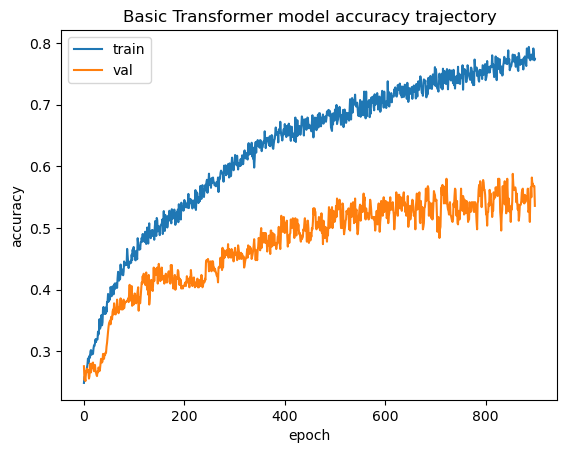

In [103]:
plt.plot(accuracy_history)
plt.plot(validation)
plt.title('Basic Transformer model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [165]:
with torch.no_grad():
                outputs = full_model(x_test.float())
                _, predicted = torch.max(outputs, 1)
                total += y_test.size(0)
                actual = torch.argmax(torch.transpose(y_test, 0, 1), dim=0)
                correct += (predicted == actual).sum().item()
                accuracy = correct / total
print("test accuracy: ", accuracy)
            

test accuracy:  0.5600666454316027


In [173]:
from torchinfo import summary
summary(full_model)

Layer (type:depth-idx)                                                      Param #
Sequential                                                                  --
├─PositionalEncoding: 1-1                                                   --
│    └─Dropout: 2-1                                                         --
├─MyTransformerModel: 1-2                                                   --
│    └─Transformer: 2-2                                                     --
│    │    └─TransformerEncoder: 3-1                                         96,472
│    │    └─TransformerDecoder: 3-2                                         100,608
│    └─Linear: 2-3                                                          345
├─TransformerClassificationHead: 1-3                                        --
│    └─AdaptiveAvgPool1d: 2-4                                               --
│    └─Linear: 2-5                                                          64
│    └─Softmax: 2-6                  